## Pretrained GAN

In [ ]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.gan import *

#Import the required libraries.

In [ ]:
path = untar_data(URLs.PETS)
path_hr = path/'images'
path_lr = path/'crappy'

# Install PETS dataset and Designate 'image' and 'crappy' path.

## Crappified data

Prepare the input data by crappifying images.

Uncomment the first time you run this notebook.

In [ ]:
from fastai.vision import *
from PIL import Image, ImageDraw, ImageFont

class crappifier(object):
    def __init__(self, path_lr, path_hr):
        self.path_lr = path_lr
        self.path_hr = path_hr              
        
    def __call__(self, fn, i):       
        dest = self.path_lr/fn.relative_to(self.path_hr)    
        dest.parent.mkdir(parents=True, exist_ok=True)
        img = PIL.Image.open(fn)
        targ_sz = resize_to(img, 96, use_min=True)
        img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
        w,h = img.size
        q = random.randint(10,70)
        ImageDraw.Draw(img).text((random.randint(0,w//2),random.randint(0,h//2)), str(q), fill=(255,255,255))
        img.save(dest, quality=q)

# 'crappifier' class creates a low resolution image. The image created becomes a model for the generator.
# The steps are as follows.
# 1. Set the path of destinatiop folder. (It stored in the dest)
# 2. Open the images with PIL library
# 3. Set the size of crappy image and resize the image
# 4. Draw a number text over the image. The number ranges from 10 to 70.
# 5. Images stores in path_lr.

In [ ]:
il = ImageList.from_folder(path_hr)
parallel(crappifier(path_lr, path_hr), il.items)

# Get imagelist
# parallel function handles functions and image lists in parallel.

For gradual resizing we can change the commented line here.

In [ ]:
bs,size=32, 128
# bs,size = 24,160
#bs,size = 8,256
arch = models.resnet34

# Designate batch size as 'bs', image size as 'size'
# Use resnet34

## Pre-train generator

Now let's pretrain the generator.

In [ ]:
arch = models.resnet34
src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)

# Make the above images a imagelist with a ratio of 0.1 of validation data.
# Specify 0.1% of the folder's image list in path_lr as the validation data list.

In [ ]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

# get_data function labels low-resolution images in response to high-resolution images.

In [ ]:
data_gen = get_data(bs,size)

# Specify the data to be used as input. It is a data mixed with high resolution images and low resolution images.

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpola

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpola

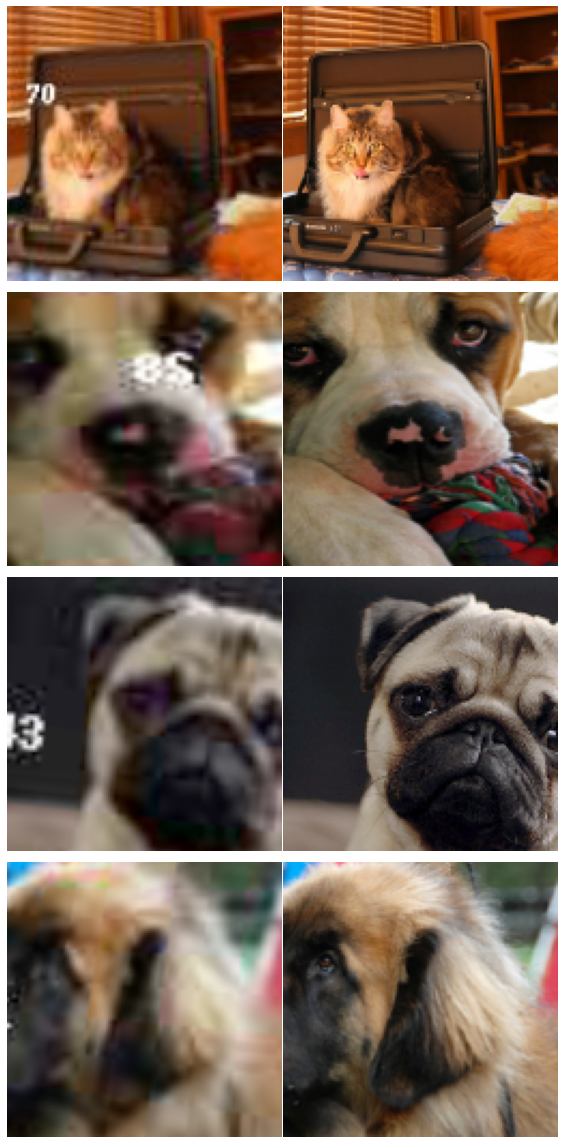

In [ ]:
data_gen.show_batch(4)

# Show images. Left column islow resolution crappy images, and right sidde is high resolution original image.

In [ ]:
wd = 1e-3

# Set the weight decay as 0.001
# This involves model regularization.

In [ ]:
y_range = (-3.,3.)

# This is the sigmoid function between +3 ~ -3. This involves model regularization too.

In [ ]:
loss_gen = MSELossFlat()

# It'll use MSELossFlat for loss function. It's useful when compare the images.
# We'll compair the generated image and original image, so MSELossFlat is goot at this notebook.

In [ ]:
def create_gen_learner():
    return unet_learner(data_gen, arch, wd=wd, blur=True, norm_type=NormType.Weight,
                         self_attention=True, y_range=y_range, loss_func=loss_gen)
    
# This function creates the unet learner which using a predefined and pre-trained ResNet34 model.

In [ ]:
learn_gen = create_gen_learner()

# Create learner using the function

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


In [ ]:
learn_gen.fit_one_cycle(2, pct_start=0.8)

# This is fastai's learning method. It changes the learning rate and makes it converge to the optimal learning.
# pct_start means percentage of iterations. The learning rate rises, and decreases again when the specified percentage is reached.

epoch,train_loss,valid_loss,time
0,0.070580,0.054391,02:25
1,0.052806,0.048033,02:23


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpola

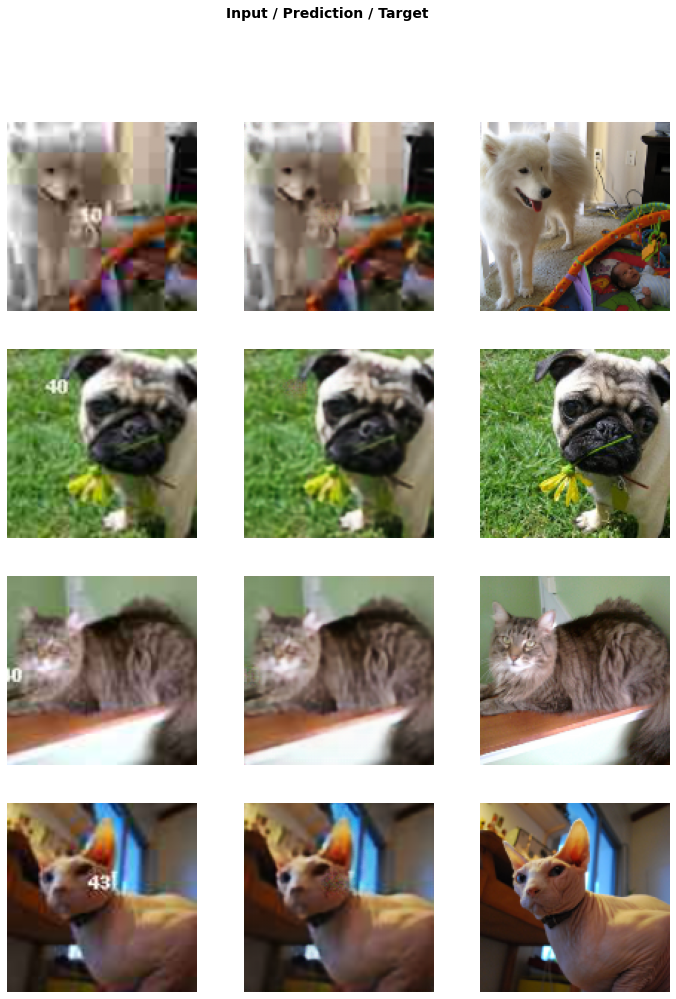

In [ ]:
learn_gen.show_results(rows=4)

In [ ]:
learn_gen.unfreeze()

# Unfreeze the learn_gen model.

In [ ]:
learn_gen.fit_one_cycle(3, slice(1e-6,1e-3))

# Run learning three more times (eporch = 3). slice Specifies the interval of the learning rate. 
# It learns by falling from high learning rate to low learning rate.(in this case, 1e-3 -> 1e-6)

In [ ]:
learn_gen.show_results(rows=4)

# show the results of learn_gen. each calums mean crappy image, predicted image by generater, and original image.

In [ ]:
learn_gen.save('gen-pre2')

# Save the pre-trained generater

## Save generated images

In [ ]:
learn_gen.load('gen-pre2');

#load gen_pre2 to learn_gen

In [ ]:
name_gen = 'image_gen'
path_gen = path/name_gen

# Create a path where we want to store the generated images. we already have the high-resolution images
# in path/image.

In [ ]:
# shutil.rmtree(path_gen)

In [ ]:
path_gen.mkdir(exist_ok=True)

# Create a directory on path_gen. The image created by the generator will now be stored in this folder.

In [ ]:
def save_preds(dl):
    i=0
    names = dl.dataset.items
    
    for b in dl:
        preds = learn_gen.pred_batch(batch=b, reconstruct=True)
        for o in preds:
            o.save(path_gen/names[i].name)
            i += 1

# The predicted image exists in the folder, so now we have th make the images into a 
# databunch that will be compared to critic.
# This function stores data in a folder of the image name.

In [ ]:
save_preds(data_gen.fix_dl)

# Perform the function. data_gen.fix_dl will Extract the predicted images to a fixed size.

In [ ]:
PIL.Image.open(path_gen.ls()[0])

# Show the first PIL image in path_gen.ls()

## Train critic

In [ ]:
learn_gen=None
gc.collect()

# Initialize what generator have learned and call garbage collecter.

Pretrain the critic on crappy vs not crappy.

In [ ]:
def get_crit_data(classes, bs, size):
    src = ImageList.from_folder(path, include=classes).split_by_rand_pct(0.1, seed=42)
    ll = src.label_from_folder(classes=classes)
    data = (ll.transform(get_transforms(max_zoom=2.), size=size)
           .databunch(bs=bs).normalize(imagenet_stats))
    data.c = 3
    return data

# Extract the images in path(PETS dataset) including 'classes' and split them 1:9.(The ratio of 1 is used as validation data.)
# And lable the images with name of each folder. Then normalise data which size were transformed.

In [ ]:
data_crit = get_crit_data([name_gen, 'images'], bs=bs, size=size)

# Now extract images which name mantioned 'name_gen, 'images'' by get_crit_data function. 

In [ ]:
data_crit.show_batch(rows=3, ds_type=DatasetType.Train, imgsize=3)

# Show the images in data_crit. There exest with high-resolution images and generated images mixed.

In [ ]:
loss_critic = AdaptiveLoss(nn.BCEWithLogitsLoss())

# The loss function applies to critic. The principle of this function
# is to change a lot of small changes and a little change of big changes. 

In [ ]:
def create_critic_learner(data, metrics):
    return Learner(data, gan_critic(), metrics=metrics, loss_func=loss_critic, wd=wd)

# bring in learners used by critics. It is a binary classifier that looks at
# images created by the generator and determines them as one of the two.

In [ ]:
learn_critic = create_critic_learner(data_crit, accuracy_thresh_expand)

# Now call the create_critic_learner. 

In [ ]:
learn_critic.fit_one_cycle(6, 1e-3)

# By training the critic learner, we give the critic the ability to
# distinguish between generator-generated images and high-resolution images.

In [ ]:
learn_critic.save('critic-pre2')

# Save learner.

## GAN

Now we'll combine those pretrained model in a GAN.

In [ ]:
learn_crit=None
learn_gen=None
gc.collect()

# Initialize what generator have learned and call garbage collecter.

In [ ]:
data_crit = get_crit_data(['crappy', 'images'], bs=bs, size=size)

# Extract carppy images by get_crit_data function. The extracted images are low-resolution images.

In [ ]:
learn_crit = create_critic_learner(data_crit, metrics=None).load('critic-pre2')

# Load the trained criric.

In [ ]:
learn_gen = create_gen_learner().load('gen-pre2')

# Load the trained generator.

To define a GAN Learner, we just have to specify the learner objects foor the generator and the critic. The switcher is a callback that decides when to switch from discriminator to generator and vice versa. Here we do as many iterations of the discriminator as needed to get its loss back < 0.5 then one iteration of the generator.

The loss of the critic is given by `learn_crit.loss_func`. We take the average of this loss function on the batch of real predictions (target 1) and the batch of fake predicitions (target 0). 

The loss of the generator is weighted sum (weights in `weights_gen`) of `learn_crit.loss_func` on the batch of fake (passed throught the critic to become predictions) with a target of 1, and the `learn_gen.loss_func` applied to the output (batch of fake) and the target (corresponding batch of superres images).

In [ ]:
switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.65)
learn = GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1.,50.), show_img=False, switcher=switcher,
                                 opt_func=partial(optim.Adam, betas=(0.,0.99)), wd=wd)
learn.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.))

# Sudden changes are not recommended because during operation the GAN continues to
# switch between the generator and the critics and exchange feedback.
# The generator and the critic are must progressively changing together.  It is used to prevent this.

In [ ]:
lr = 1e-4

# Set the learning rate as 0.0001

In [ ]:
learn.fit(40,lr)

# The smarter a generator becomes, the harder it becomes for a critic to answer.
# Therefore, critic develop more to answer. If the critic gets the answer right,
# the generator finds a complementary point and develops further.
# So the two of them go together complementary.
# The loss value shows how generator and critic develop.

In [ ]:
learn.save('gan-1c')

# save learn

In [ ]:
learn.data=get_data(16,192)

# Make the crappy images again. batch size=16, image size = 192.

In [ ]:
learn.fit(10,lr/2)

# learn the generator and critic model again.

In [ ]:
learn.show_results(rows=16)

# Show results. It can be seen that the image created by the geneartor has developed further.
# For example, the border of cats became clearer compared to before.

In [ ]:
learn.save('gan-1c')

# Save this samart learner.

## fin